In [1]:
import pandas as pd

# Load monthly dataset
monthly_df = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\cap 735 project\\food_price_index_(1990-2022)_monthly.csv")

# First row contains headers
monthly_df.columns = monthly_df.iloc[0]
monthly_df = monthly_df.drop(0)

# Drop columns with all NaN values
monthly_df = monthly_df.dropna(axis=1, how='all')

# Convert Date column to datetime
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'], errors='coerce')

# Convert all numeric columns to float
for col in monthly_df.columns:
    if col != 'Date':
        monthly_df[col] = pd.to_numeric(monthly_df[col], errors='coerce')

# Fill missing values forward
monthly_df = monthly_df.fillna(method='ffill')

print(monthly_df.head())


0       Date  Food Price Index  Meat  Dairy  Cereals   Oils  Sugar  NaN
1 1990-01-01              64.1  73.4   53.5     64.1  44.59   87.9  NaN
2 1990-02-01              64.5  76.0   52.2     62.2  44.50   90.7  NaN
3 1990-03-01              63.8  77.8   41.4     61.3  45.75   95.1  NaN
4 1990-04-01              65.8  80.4   48.4     62.8  44.02   94.3  NaN
5 1990-05-01              64.4  81.0   39.2     62.0  45.50   90.4  NaN


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15660\196358330.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_df = monthly_df.fillna(method='ffill')


In [2]:
# Load annual dataset
annual_df = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\cap 735 project\\food_price_index_(2004-2021)_anually.csv")

# First row contains headers
annual_df.columns = annual_df.iloc[0]
annual_df = annual_df.drop(0)

# Drop columns with all NaN values
annual_df = annual_df.dropna(axis=1, how='all')

# Rename YEAR to Date and convert to datetime
if 'YEAR' in annual_df.columns:
    annual_df.rename(columns={'YEAR': 'Date'}, inplace=True)
annual_df['Date'] = pd.to_datetime(annual_df['Date'], format='%Y', errors='coerce')

# Convert all numeric columns to float (replace commas if needed)
for col in annual_df.columns:
    if col != 'Date':
        annual_df[col] = annual_df[col].astype(str).str.replace(',', '.')
        annual_df[col] = pd.to_numeric(annual_df[col], errors='coerce')

# Fill missing values forward
annual_df = annual_df.fillna(method='ffill')

print(annual_df.head())


0  NaN       Date  INDEX  MEAT  DAIRY  CEREALS   OILS  SUGAR
1  0.0 2004-01-01   65.6  67.6   69.8     64.0   69.6   44.3
2  1.0 2005-01-01   67.4  71.8   77.2     60.8   64.4   61.2
3  2.0 2006-01-01   72.6  70.5   73.1     71.2   70.5   91.4
4  3.0 2007-01-01   94.3  76.9  122.4    100.9  107.3   62.4
5  4.0 2008-01-01  117.5  90.2  132.3    137.6  141.1   79.2


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15660\4227615319.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  annual_df = annual_df.fillna(method='ffill')


In [4]:
monthly_df.to_csv(r"C:\\Users\\Lenovo\\Documents\\food_price_index_monthly_clean.csv", index=False)
annual_df.to_csv(r"C:\\Users\\Lenovo\\Documents\\food_price_index_annual_clean.csv", index=False)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
monthly_df = pd.read_csv("C:\\Users\\Lenovo\\Documents\\food_price_index_monthly_clean.csv")

In [8]:
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.sort_values('Date', inplace=True)
monthly_df['Year'] = monthly_df['Date'].dt.year
monthly_df['Month'] = monthly_df['Date'].dt.month
monthly_df['Month_Name'] = monthly_df['Date'].dt.strftime('%b')

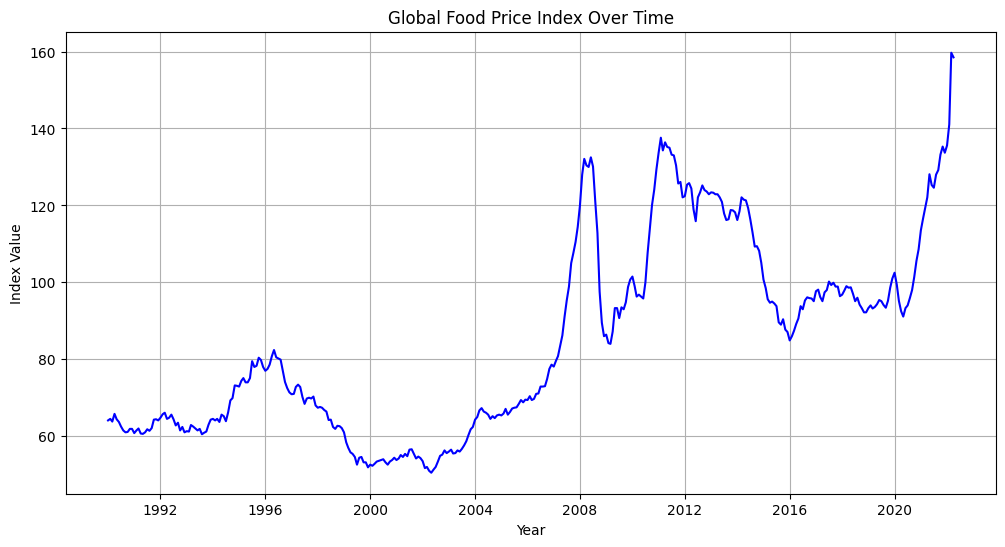

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_df['Date'], monthly_df['Food Price Index'], color='blue')
plt.title("Global Food Price Index Over Time")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.grid(True)
plt.show()

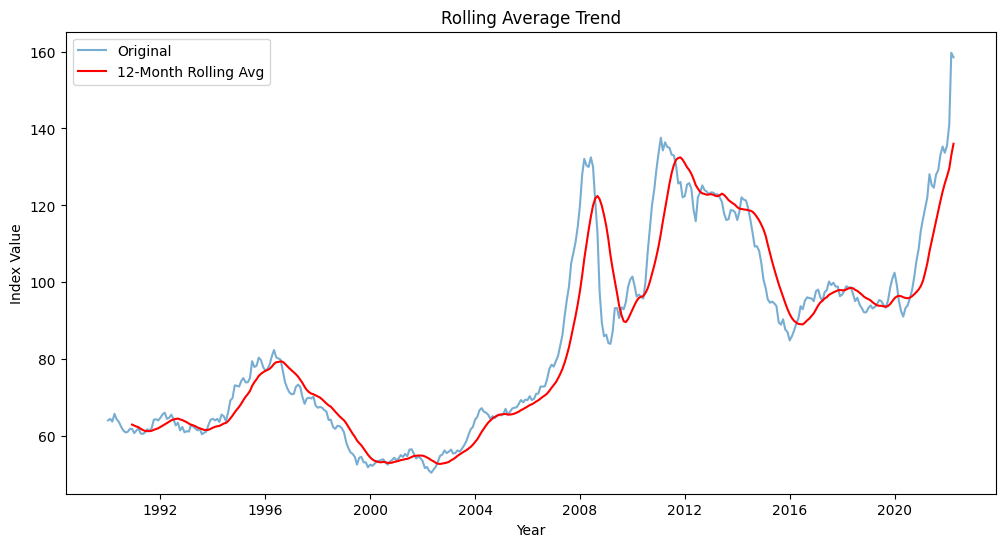

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_df['Date'], monthly_df['Food Price Index'], label="Original", alpha=0.6)
plt.plot(monthly_df['Date'], monthly_df['Food Price Index'].rolling(window=12).mean(), label="12-Month Rolling Avg", color='red')
plt.title("Rolling Average Trend")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.legend()
plt.show()

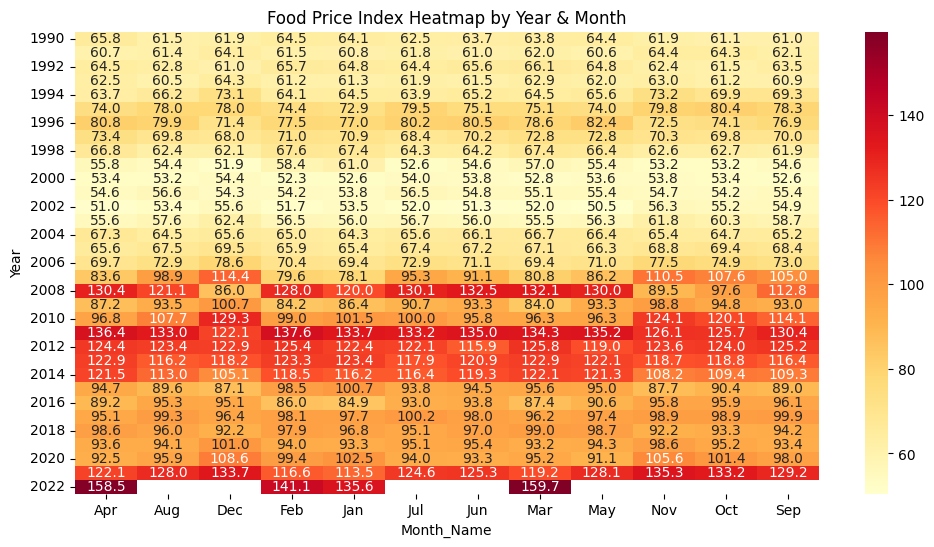

In [11]:
pivot_df = monthly_df.pivot_table(values='Food Price Index', index='Year', columns='Month_Name')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlOrRd", annot=True, fmt=".1f")
plt.title("Food Price Index Heatmap by Year & Month")
plt.show()

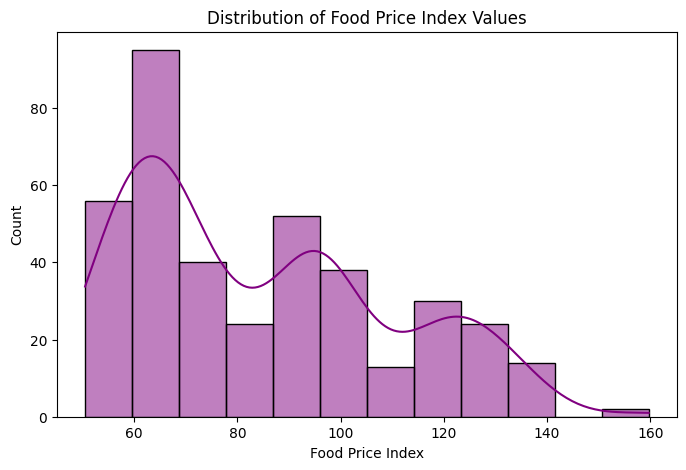

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(monthly_df['Food Price Index'], kde=True, color='purple')
plt.title("Distribution of Food Price Index Values")
plt.show()

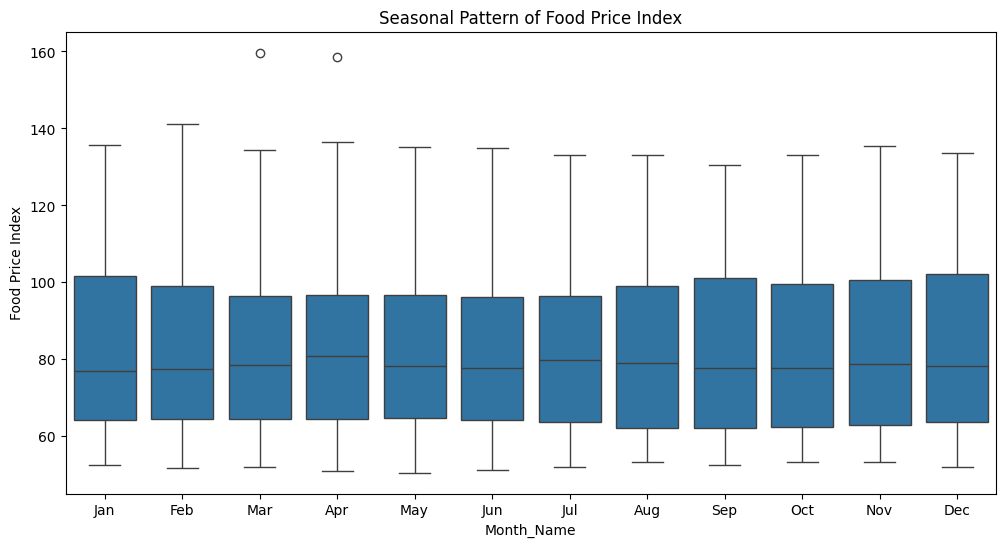

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month_Name', y='Food Price Index', data=monthly_df, order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("Seasonal Pattern of Food Price Index")
plt.show()

In [14]:
train = monthly_df[:-12]
test = monthly_df[-12:]

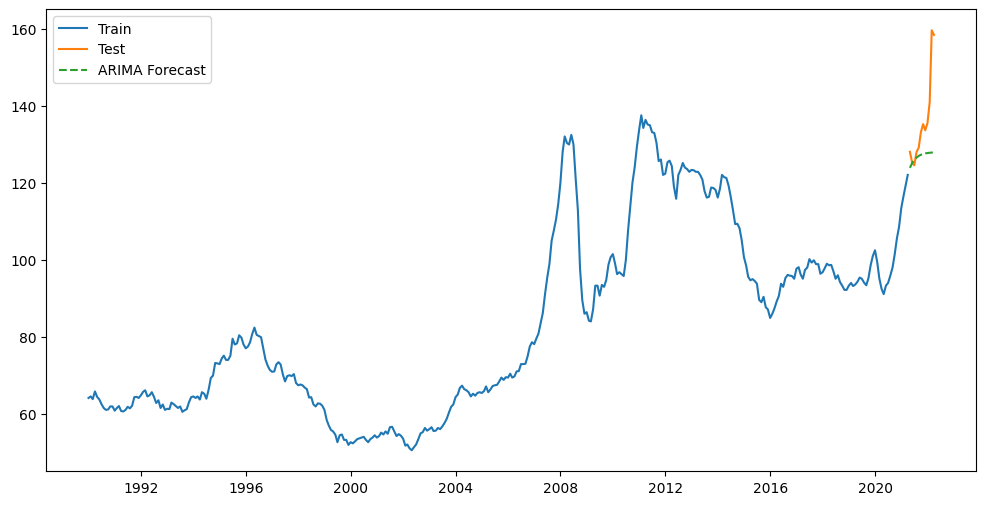

In [15]:
arima_model = ARIMA(train['Food Price Index'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=12)

plt.figure(figsize=(12,6))
plt.plot(train['Date'], train['Food Price Index'], label='Train')
plt.plot(test['Date'], test['Food Price Index'], label='Test')
plt.plot(test['Date'], arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.show()

14:26:26 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


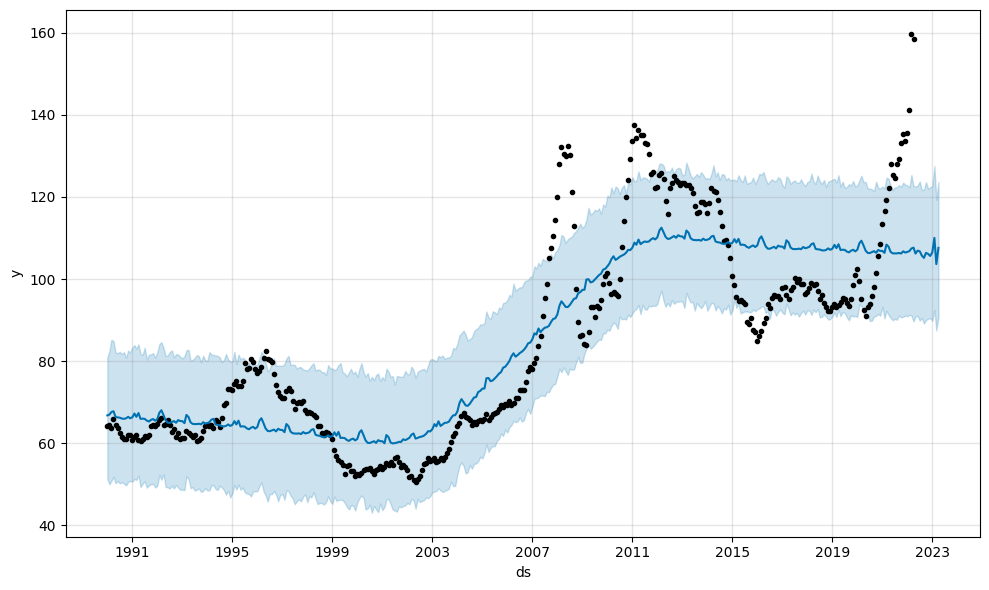

In [16]:
prophet_df = monthly_df.rename(columns={"Date": "ds", "Food Price Index": "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.show()

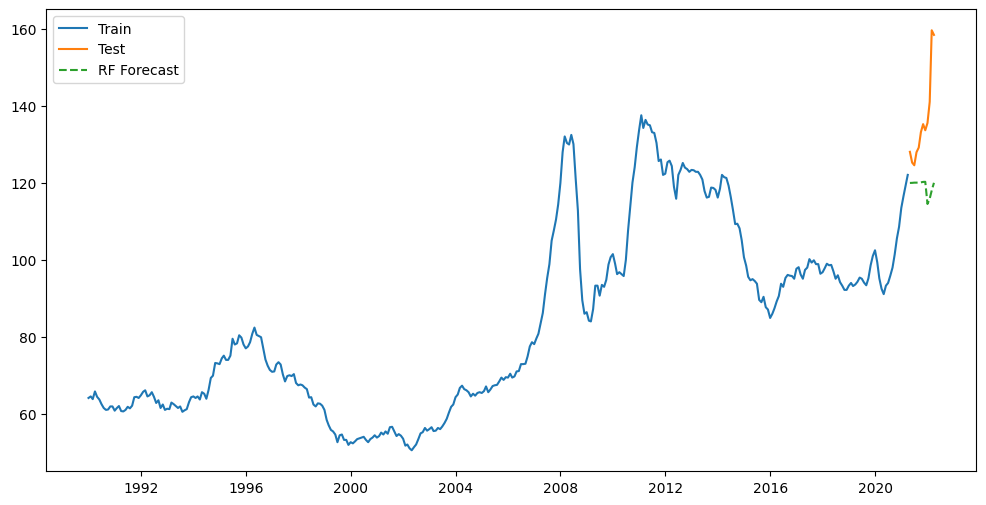

In [17]:
features = ['Year', 'Month']
target = 'Food Price Index'

train_rf = monthly_df.iloc[:-12]
test_rf = monthly_df.iloc[-12:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_rf[features], train_rf[target])

rf_preds = rf_model.predict(test_rf[features])

plt.figure(figsize=(12,6))
plt.plot(train_rf['Date'], train_rf[target], label='Train')
plt.plot(test_rf['Date'], test_rf[target], label='Test')
plt.plot(test_rf['Date'], rf_preds, label='RF Forecast', linestyle='--')
plt.legend()
plt.show()

In [18]:
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test['Food Price Index'], arima_forecast)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(test_rf[target], rf_preds)))
print("Random Forest R2:", r2_score(test_rf[target], rf_preds))

ARIMA RMSE: 13.95878823178948
Random Forest RMSE: 20.664732152066723
Random Forest R2: -2.360636309472034


In [1]:
monthly_df.info()
annual_df.info()

NameError: name 'monthly_df' is not defined